# 轻松构建 PyTorch 生成对抗网络(GAN)

### 创建Notebook实例

*如果您已经了解 Amazon SageMaker Notebook 的创建方法，请跳过本小结。*

* 请打开 Amazon SageMaker 的仪表板（点击打开 [北京区域](https://cn-north-1.console.amazonaws.cn/sagemaker/home?region=cn-north-1#/dashboard) | [宁夏区域](https://cn-northwest-1.console.amazonaws.cn/sagemaker/home?region=cn-northwest-1#/dashboard) ），点击 `Notebook instances` 按钮进入笔记本实例列表。

* 如果您是第一次使用Amazon SageMaker，您的 `Notebook instances` 列表将显示为空列表，此时您需点击 `Create notebook instance` 按钮来创建全新 Jupyter Notebook 实例。

* 进入 `Create notebook instance` 页面后，请在 `Notebook instance name` 字段里输入实例名字，本文将使用 MySageMakerInstance 作为实例名，您可以选用您认为合适的名字。本文将使用默认的实例类型，因此 `Notebook instance type` 选项将保持为 ml.t2.medium。

* 如果您是第一次使用Amazon SageMaker，您需要创建一个 IAM role，以便笔记本实例能够访问 Amazon S3 服务。请在 `IAM role` 选项点击为 `Create a new role`。Amazon SageMaker 将创建一个具有必要权限的角色，并将这个角色分配给正在创建的实例。另外，根据您的实际情况，您也可以选择一个已经存在的角色。

* 在 `Create an IAM role` 弹出窗口里，您可以选择 Any S3 bucket，这样笔记本实例将能够访问您账户里的所有桶。另外，根据您的需要，您还可以选择 *Specific S3 buckets* 并输入桶名。点击 `Create role` 按钮，这个新角色将被创建。

* 此时，可以看到 Amazon SageMaker 为您创建了一个名字类似 `AmazonSageMaker-ExecutionRole-***` 的角色。对于其他字段，您可以采取默认值，请点击 `Create notebook instance` 按钮，创建实例。

* 回到 `Notebook instances` 页面，您会看到 MySageMakerInstance 笔记本实例显示为 `Pending` 状态，这个将持续2分钟左右，直到转为 `InService` 状态。

### 编写第一行代码

*如果您已经了解 Amazon SageMaker Notebook 的使用方法，请跳过本小结。*

点击 `Open JupyterLab` 链接，在新的页面里，您将看到熟悉的 Jupyter Notebook 加载界面。本文默认以 JupyterLab 笔记本作为工程环境，根据您的需要，可以选择使用传统的 Jupyter 笔记本。

您将通过点击 `conda_pytorch_p36` 笔记本图标来创建一个叫做 Untitled.ipynb 的笔记本，您可以稍后更改它的名字。另外，您也可以通过 `File > New > Notebook` 菜单路径，并选择 `conda_pytorch_p36` 作为 `Kernel` 来创建这个笔记本。

在新建的 Untitled.ipynb 笔记本里，我们将输入第一行指令如下，

In [1]:
import torch

print(f"Hello PyTorch {torch.__version__}")

Hello PyTorch 1.4.0


### 源代码下载

您将使用下面指令下载代码到实例本地文件系统。

In [ ]:
!git clone "https://github.com/mf523/ml-on-aws.git" "ml-on-aws"

您可以通过 `File browser` 浏览源代码结构。

项目目录 /ml-on-aws/byom-pytorch-gan 的文件结构如下，

文件 model.py 中包含 2 个类，分别是 生成网络 Generator 和 判别网络 Discriminator。

文件 train.py 用于 Generator 和 Discriminator 两个神经网络的训练。

### 数据准备

互联网环境里有很多公开的数据集，对于机器学习的模型训练和算法评价很有帮，我们将使用QMNIST手写数字数据集训练这个生成对抗网络，并最终生成逼真的『手写』字体效果图样。

PyTorch 框架的 torchvision.datasets 包提供了QMNIST数据集，我们通过如下指令下载 QMNIST 数据集备用。

In [29]:
from torchvision import datasets

dataset = 'qmnist'
dataroot = './data'

if dataset == 'mnist':

    trainset = datasets.MNIST(root=dataroot, train=True, download=True)
    testset = datasets.MNIST(root=dataroot, train=False, download=True)
elif dataset == 'qmnist':

    trainset = datasets.QMNIST(root=dataroot, train=True, download=True)
    testset = datasets.QMNIST(root=dataroot, train=False, download=True)
elif dataset == 'cifar10':

    trainset = datasets.CIFAR10(root=dataroot, train=True, download=True)
    testset = datasets.CIFAR10(root=dataroot, train=False, download=True)
else:
    raise ValueError(f"unknown dataset '{dataset}'")
    

In [42]:
confsets = {
        'mnist':{'subfolder': 'MNIST',
                     'hps': {
                         'seed': 0,
                         'learning-rate': 0.0002,
                         'epochs': 10,
                         'dataset': dataset,
                         'pin-memory': 1,
                         'beta1': 0.5,
                         'nc': 1,
                         'nz': 100,
                         'ngf': 64,
                         'ndf': 64,
                         'batch-size': 64,
                         'sample-interval': 100,
                         'log-interval': 20,
                     }
                },
        'qmnist':{'subfolder': 'QMNIST',
                     'hps': {
                         'seed': 0,
                         'learning-rate': 0.0002,
                         'epochs': 10,
                         'dataset': dataset,
                         'pin-memory': 1,
                         'beta1': 0.5,
                         'nc': 1,
                         'nz': 100,
                         'ngf': 64,
                         'ndf': 64,
                         'batch-size': 64,
                         'sample-interval': 100,
                         'log-interval': 20,
                     }
                },
        'cifar10':{'subfolder': 'cifar-10-batches-py',
                     'hps': {
                         'seed': 0,
                         'learning-rate': 0.0002,
                         'epochs': 10,
                         'dataset': dataset,
                         'pin-memory': 1,
                         'beta1': 0.5,
                         'nc': 3,
                         'nz': 100,
                         'ngf': 64,
                         'ndf': 64,
                         'batch-size': 64,
                         'sample-interval': 100,
                         'log-interval': 20,
                     }
                }
       }



subfolder = confsets[dataset]['subfolder']

Amazon SageMaker 为您创建了一个默认的 Amazon S3 桶，用来存取机器学习工作流程中可能需要的各种文件和数据。
我们可以通过 SageMaker SDK中 sagemaker.session.Session 类的 default_bucket() 方法获得这个桶的名字。

In [31]:
from sagemaker.session import Session

sess = Session()

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket here if you wish.
bucket = sess.default_bucket()

# Location to save your custom code in tar.gz format.
s3_custom_code_upload_location = f's3://{bucket}/customcode/byom-pytorch-gan'

# Location where results of model training are saved.
s3_model_artifacts_location =f's3://{bucket}/artifacts/'

请执行如下指令将已经下载的数据上传至 Amazon S3，供模型训练使用。模型训练过程不需要从互联网下载数据，进而降低了获取训练数据的产生延迟，同时也规避了因直接访问互联网对模型训练可能产生的安全风险。

In [32]:
import os
from sagemaker.s3 import S3Uploader as s3up

s3_data_location = s3up.upload(os.path.join(dataroot, subfolder), f"s3://{bucket}/data/{dataset}")

### 训练执行




通过 sagemaker.get_execution_role() 方法，当前笔记本可以得到预先分配给笔记本实例的角色，这个角色将被用来获取训练用的资源，比如 Amazon EC2。

In [ ]:
from sagemaker import get_execution_role

# IAM execution role that gives SageMaker access to resources in your AWS account.
# We can use the SageMaker Python SDK to get the role from our notebook environment. 
role = get_execution_role()

训练模型用的超参数可以在笔记本里定义，与算法代码分离，在创建训练任务时传入，与训练任务动态结合。

In [34]:
import json

hps = confsets[dataset]['hps']
epochs = hps['epochs']
nc = hps['nc']
nz = hps['nz']
ngf = hps['ngf']
ndf = hps['ndf']
batch_size = hps['batch-size']

print(json.dumps(hps, indent = 4))

{
    "seed": 0,
    "learning-rate": 0.0002,
    "epochs": 5,
    "dataset": "qmnist",
    "pin-memory": 1,
    "beta1": 0.5,
    "nc": 1,
    "nz": 100,
    "ngf": 64,
    "ndf": 64,
    "batch-size": 64,
    "sample-interval": 100,
    "log-interval": 20
}


您可以使用 ```PyTorch``` 类创建训练任务。参数 ``train_instance_type`` 可以用来指定CPU或者GPU实例类型，训练脚本和包括模型代码所在的目录通过 ``source_dir`` 指定，训练脚本文件名必须通过 ``entry_point`` 明确定义。这些参数将和其余参数一起被传递给训练任务，决定了训练任务的运行环境和模型训练时参数。

In [35]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(role=role,
                        entry_point='train.py',
                        source_dir='dcgan',
                        output_path=s3_model_artifacts_location,
                        code_location=s3_custom_code_upload_location,
                        train_instance_count=1,
#                         train_instance_type='local',
                        train_instance_type='ml.p3.2xlarge',
#                         train_instance_type='ml.g4dn.xlarge',
#                         train_instance_type='ml.c5.large',
                        train_use_spot_instances=True,
                        train_max_wait=86400,
                        framework_version='1.4.0',
                        py_version='py3',
                        hyperparameters=hps)

您已经创建了 PyTorch 对象，下面您可以用它来拟合预先存在 Amazon S3 上的数据了。下面的指令将执行训练任务，训练数据将以名为 **QMNIST** 的输入通道的方式导入训练环境。训练执行过程中，Amazon S3 上的训练数据将被下载到模型训练环境的本地文件系统，```train.py``` 脚本从本地磁盘加载数据进行训练。



In [36]:
%%time
# Start training
estimator.fit({subfolder: s3_data_location}, wait=False)

CPU times: user 47.4 ms, sys: 7.07 ms, total: 54.5 ms
Wall time: 356 ms


In [37]:
%%time
from sagemaker.estimator import Estimator

# Attaching previous training session
training_job_name = estimator.latest_training_job.name
attached_estimator = Estimator.attach(training_job_name)

2020-04-06 17:03:38 Starting - Starting the training job...
2020-04-06 17:03:40 Starting - Launching requested ML instances......
2020-04-06 17:04:42 Starting - Preparing the instances for training......
2020-04-06 17:06:01 Downloading - Downloading input data
2020-04-06 17:06:01 Training - Downloading the training image..........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-06 17:07:41,385 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-06 17:07:41,409 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-06 17:07:42,824 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-06 17:07:43,104 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020-04-06 17:07:43,105 sagemaker-containers INFO     Generating setup.cfg
2020-04-06 17:07:43,10

根据您选择的训练实例不同，训练过程中可能持续几十分钟到几个小时不等，通常GPU实例会更快，例如，p3.2xlarge 实例大概需要16分钟左右，而 c5.xlarge 实例则可能需要10小时左右。

训练完成后，模型将被上传到 Amazon S3 里，上传位置由创建 `PyTorch` 对象时提供的 `output_path` 参数指定。

### 模型的验证

您将从 Amazon S3 下载经过训练的模型到笔记本所在实例本地文件系统。

执行如下指令找到刚刚训练好的模型。

In [38]:
from helper import *

last_artifact_location = s3_model_artifacts_location + training_job_name

last_model_url = get_object_path_by_filename(last_artifact_location, 'model.tar.gz')
last_output_url = get_object_path_by_filename(last_artifact_location, 'output.tar.gz')

print(last_model_url)
print(last_output_url)
!rm -rf ./tmp/* ./model/*

s3://sagemaker-us-west-2-533025023261/artifacts/pytorch-training-2020-04-06-17-03-38-248/output/model.tar.gz
s3://sagemaker-us-west-2-533025023261/artifacts/pytorch-training-2020-04-06-17-03-38-248/output/output.tar.gz


In [39]:
from sagemaker.s3 import S3Downloader as s3down

s3down.download(last_model_url, './tmp')
s3down.download(last_output_url, './tmp')

In [40]:
!tar -zxf tmp/model.tar.gz -C ./tmp
!tar -zxf tmp/output.tar.gz -C ./tmp
!cp ./tmp/generator_state.pth ./model

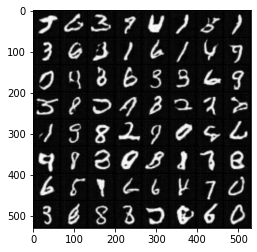

In [41]:
from helper import *
import matplotlib.pyplot as plt
import numpy as np
import torch
from dcgan.model import Generator

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

params = {'nz': nz, 'nc': nc, 'ngf': ngf}
model = load_model(Generator, params, "./model/generator_state.pth", device=device)
img = generate_fake_handwriting(model, batch_size=batch_size, nz=nz, device=device)

plt.imshow(np.asarray(img))

### Install packages

### Optimize your model with Neo API
Neo API allows to optimize our model for a specific hardware type. When calling `compile_model()` function, we specify the target instance family (C5) as well as the S3 bucket to which the compiled model would be stored.

**Important. If the following command result in a permission error, scroll up and locate the value of execution role returned by `get_execution_role()`. The role must have access to the S3 bucket specified in ``output_path``.**

In [ ]:
output_path = '/'.join(estimator.output_path.split('/')[:-1])
compiled_model = estimator.compile_model(target_instance_family='jetson_tx2',
                                               input_shape={'input0':[1, 784]},
                                               role=role,
                                               output_path=output_path)

### Creating an inference Endpoint

We can deploy this compiled model, note that we need to use the same instance that the target we used for compilation. This creates a SageMaker endpoint that we can use to perform inference. 

The arguments to the ``deploy`` function allow us to set the number and type of instances that will be used for the Endpoint. Make sure to choose an instance for which you have compiled your model, so in our case  `ml_c5`. Neo API uses a special runtime (DLR runtime), in which our optimzed model will run.

In [ ]:
predictor = mnist_estimator.deploy(initial_instance_count = 1, instance_type = 'ml.c5.2xlarge')

This endpoint will receive uncompressed NumPy arrays, whose Content-Type is given as `application/vnd+python.numpy+binary`:

In [ ]:
import io
import numpy as np
def numpy_bytes_serializer(data):
    f = io.BytesIO()
    np.save(f, data)
    f.seek(0)
    return f.read()

predictor.content_type = 'application/vnd+python.numpy+binary'
predictor.serializer = numpy_bytes_serializer

### Making an inference request

Now that our Endpoint is deployed and we have a ``predictor`` object, we can use it to classify handwritten digits.

To see inference in action, draw a digit in the image box below. The pixel data from your drawing will be loaded into a ``data`` variable in this notebook. 

*Note: after drawing the image, you'll need to move to the next notebook cell.*

Now we can use the ``predictor`` object to classify the handwritten digit:

## Conclusion
---
SageMaker Neo automatically optimizes machine learning models to perform at up to fourth the speed with no loss in accuracy. In the diagram below shows you how our neo-optimized model performs better than the original mxnet mnist model. The originl model stands for the uncompiled model deployed on Flask container on May 26th, 2019 and neo-optimized model stands for the compiled model deployed on Neo-AI-DLR container. The data for each trial is the average of 1000 trys for each endpoint.
![alt text](mxnet-byom-latency.png "Title")

# (Optional) Delete the Endpoint

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it.

In [ ]:
print("Endpoint name: " + predictor.endpoint)

In [ ]:
import sagemaker
predictor.delete_endpoint()